0. Installing package and setup environment

In [1]:
!nvidia-smi

Sat Jun 24 09:15:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |      0MiB / 15360MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!huggingface-cli login --token ${YOUR_HF_TOKEN} 

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/lx/.cache/huggingface/token
Login successful


---

1. Load dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset("keremberke/chest-xray-classification", "full")

Found cached dataset chest-xray-classification (/home/lx/.cache/huggingface/datasets/keremberke___chest-xray-classification/full/1.0.0/34d5a3d96ebfc454a409411badbd8596202f787803c69e0ba42791bbd6a12c28)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4077
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1165
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 582
    })
})

In [5]:
dataset["train"].features

{'image_file_path': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'labels': ClassLabel(names=['NORMAL', 'PNEUMONIA'], id=None)}

In [6]:
dataset["train"][0]

{'image_file_path': '/home/lx/.cache/huggingface/datasets/downloads/extracted/c20a745d169f58684f8b65775596822155c6362d0936471e185404d2c52b1965/NORMAL/IM-0003-0001_jpeg.rf.3fffcf9c33575f8f928b017484f99a64.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'labels': 0}

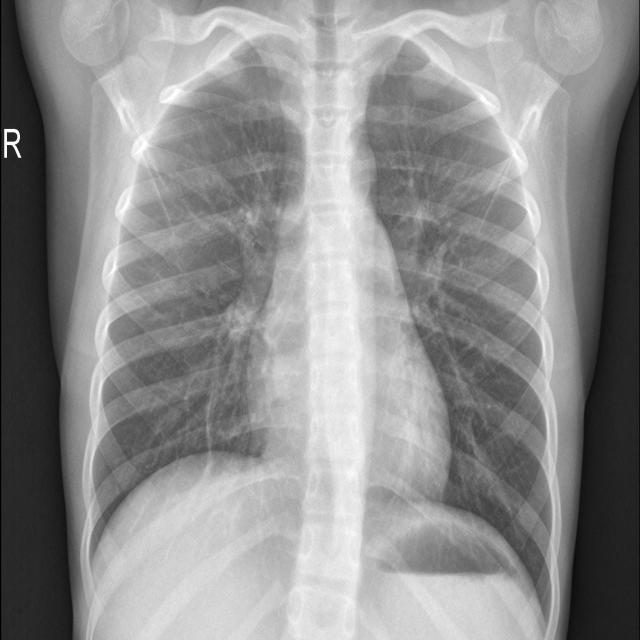

In [7]:
dataset["train"][0]["image"]

In [8]:
# ['NORMAL', 'PNEUMONIA']
labels = dataset["train"].features["labels"].names 
id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

id2label

{0: 'NORMAL', 1: 'PNEUMONIA'}

----

2. Preprocessing the data

In [9]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]

In [10]:
processor.size

{'height': 224, 'width': 224}

In [11]:
image_mean, image_std

([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

In [32]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
size = (
    processor.size["shortest_edge"]
    if "shortest_edge" in processor.size
    else (processor.size["height"], processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [12]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [33]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [34]:
train_ds = dataset["train"]
val_ds = dataset["validation"]
test_ds = dataset["test"]

# use set_transform to perform data-aug on the fly; transformation being applied when examples are accessed
train_ds.set_transform(transforms)
val_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [35]:
train_ds[:2]

{'image_file_path': ['/home/lx/.cache/huggingface/datasets/downloads/extracted/c20a745d169f58684f8b65775596822155c6362d0936471e185404d2c52b1965/NORMAL/IM-0003-0001_jpeg.rf.3fffcf9c33575f8f928b017484f99a64.jpg',
  '/home/lx/.cache/huggingface/datasets/downloads/extracted/c20a745d169f58684f8b65775596822155c6362d0936471e185404d2c52b1965/NORMAL/IM-0006-0001_jpeg.rf.75b1553d7514f898d58eccd723dcf0d3.jpg'],
 'labels': [0, 0],
 'pixel_values': [tensor([[[0.4824, 0.4980, 0.5137,  ..., 0.1373, 0.0824, 0.0431],
           [0.4745, 0.4902, 0.4980,  ..., 0.1608, 0.1137, 0.0745],
           [0.4588, 0.4667, 0.4588,  ..., 0.1922, 0.1608, 0.1294],
           ...,
           [0.5686, 0.5608, 0.5529,  ..., 0.6706, 0.6706, 0.6627],
           [0.5843, 0.5765, 0.5765,  ..., 0.6784, 0.6706, 0.6706],
           [0.5765, 0.5765, 0.5765,  ..., 0.6784, 0.6784, 0.6784]],
  
          [[0.4824, 0.4980, 0.5137,  ..., 0.1373, 0.0824, 0.0431],
           [0.4745, 0.4902, 0.4980,  ..., 0.1608, 0.1137, 0.0745],
     

In [36]:
train_ds[:2]["pixel_values"][0].shape

torch.Size([3, 224, 224])

In [16]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([item["pixel_values"] for item in examples])
    labels = torch.tensor([item["labels"] for item in examples])
    return {
        "pixel_values": pixel_values,
        "labels": labels
    }

In [17]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

----

Evaluate

In [18]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

---

Train

In [19]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
training_args = TrainingArguments(
    output_dir="vit-xray-pneumonia-classification",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    save_total_limit=2,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,
    push_to_hub=True,
    report_to="tensorboard"
)

In [37]:
from transformers import EarlyStoppingCallback

early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)

/home/lx/playgrounds/notebooks/vit-xray-pneumonia-classification is already a clone of https://huggingface.co/lxyuan/vit-xray-pneumonia-classification. Make sure you pull the latest changes with `repo.git_pull()`.


In [38]:
trainer.train()

/home/lx/env37/lib/python3.7/site-packages/transformers/optimization.py:415: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy
0,0.515200,0.250719,0.924464
1,0.233400,0.176551,0.938197
2,0.164700,0.121793,0.958798
4,0.144000,0.122181,0.950215
4,0.134800,0.129320,0.957082
5,0.127600,0.099960,0.966524
6,0.117500,0.117716,0.950215
8,0.109000,0.107927,0.966524
8,0.091400,0.080373,0.971674
9,0.087200,0.080006,0.971674


TrainOutput(global_step=828, training_loss=0.15108355059139972, metrics={'train_runtime': 1348.9403, 'train_samples_per_second': 45.336, 'train_steps_per_second': 0.701, 'total_flos': 4.1071529415629906e+18, 'train_loss': 0.15108355059139972, 'epoch': 12.99})

In [39]:
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/327M [00:00<?, ?B/s]

Upload file runs/Jun24_09-42-44_deep-learning-vm1/events.out.tfevents.1687600080.deep-learning-vm1.11964.1:   …

To https://huggingface.co/lxyuan/vit-xray-pneumonia-classification
   a76e799..2eb3972  main -> main

To https://huggingface.co/lxyuan/vit-xray-pneumonia-classification
   2eb3972..0c65f71  main -> main



'https://huggingface.co/lxyuan/vit-xray-pneumonia-classification/commit/2eb397277c9712aaf130771bf6435abf3db09ec8'

In [40]:
processor.push_to_hub("vit-xray-pneumonia-classification")

CommitInfo(commit_url='https://huggingface.co/lxyuan/vit-xray-pneumonia-classification/commit/7d162958fbfbb268e5a4542e6d10c1bad54520f7', commit_message='Upload processor', commit_description='', oid='7d162958fbfbb268e5a4542e6d10c1bad54520f7', pr_url=None, pr_revision=None, pr_num=None)

In [42]:
trainer.evaluate(train_ds)

{'eval_loss': 0.07578657567501068,
 'eval_accuracy': 0.9776796664213883,
 'eval_runtime': 38.0289,
 'eval_samples_per_second': 107.208,
 'eval_steps_per_second': 6.705,
 'epoch': 12.99}

In [43]:
trainer.evaluate(test_ds)

{'eval_loss': 0.12607704102993011,
 'eval_accuracy': 0.9587628865979382,
 'eval_runtime': 6.2076,
 'eval_samples_per_second': 93.756,
 'eval_steps_per_second': 5.96,
 'epoch': 12.99}

In [45]:
trainer.evaluate(val_ds)

{'eval_loss': 0.08536002039909363,
 'eval_accuracy': 0.9716738197424892,
 'eval_runtime': 10.9371,
 'eval_samples_per_second': 106.518,
 'eval_steps_per_second': 6.675,
 'epoch': 12.99}

----

Inference

In [48]:
mini_dataset = load_dataset("keremberke/chest-xray-classification", "mini")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset chest-xray-classification downloaded and prepared to /home/lx/.cache/huggingface/datasets/keremberke___chest-xray-classification/mini/1.0.0/34d5a3d96ebfc454a409411badbd8596202f787803c69e0ba42791bbd6a12c28. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [49]:
mini_dataset

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4
    })
})

In [50]:
test_img = mini_dataset["train"][0]["image"]

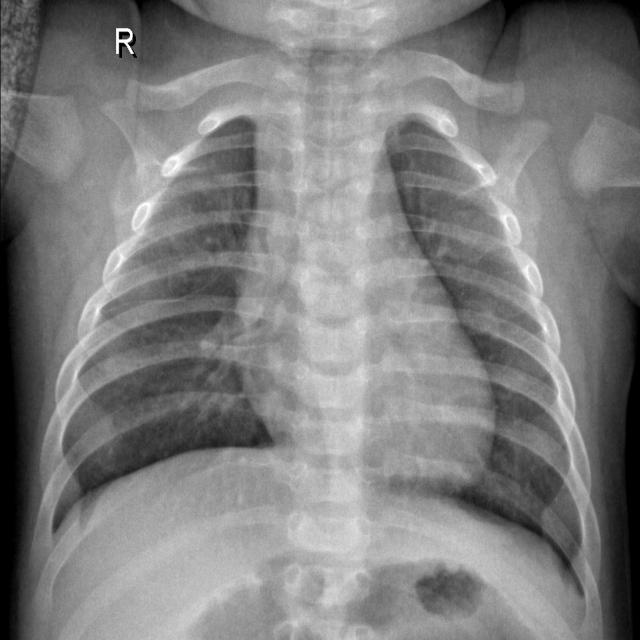

In [51]:
test_img

In [52]:
mini_dataset["train"][0]["labels"]

0

In [53]:
from transformers import pipeline

classifier = pipeline("image-classification", model="./vit-xray-pneumonia-classification")
classifier(test_img)

[{'score': 0.9894798398017883, 'label': 'NORMAL'},
 {'score': 0.010520228184759617, 'label': 'PNEUMONIA'}]

In [54]:
classifier(test_img, top_k=1)

[{'score': 0.9894798398017883, 'label': 'NORMAL'}]

----

Evaluate test set using evaluator

In [61]:
reload_test_set = load_dataset("keremberke/chest-xray-classification", "full", split="test")

Found cached dataset chest-xray-classification (/home/lx/.cache/huggingface/datasets/keremberke___chest-xray-classification/full/1.0.0/34d5a3d96ebfc454a409411badbd8596202f787803c69e0ba42791bbd6a12c28)


In [62]:
reload_test_set

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 582
})

In [63]:
trainer.model.config.label2id

{'NORMAL': 0, 'PNEUMONIA': 1}

In [64]:
from evaluate import evaluator

task_evaluator = evaluator("image-classification")

results = task_evaluator.compute(
    model_or_pipeline=classifier,
    data=reload_test_set,
    metric=evaluate.combine([
        "accuracy",
        #evaluate.load("f1", average="macro")
    ]),
    tokenizer=processor,
    label_mapping=trainer.model.config.label2id,
    label_column="labels",
    strategy="simple",
)


In [65]:
results

{'accuracy': 0.9673539518900344,
 'total_time_in_seconds': 249.36542128899964,
 'samples_per_second': 2.3339242345292806,
 'latency_in_seconds': 0.4284629231769753}

----

Load the last epoch model into pipeline

In [74]:
from transformers import pipeline

classifier = pipeline("image-classification", model="./vit-xray-pneumonia-classification/checkpoint-828/")
classifier(test_img)

[{'score': 0.9918408393859863, 'label': 'NORMAL'},
 {'score': 0.008159122429788113, 'label': 'PNEUMONIA'}]

In [75]:
results = task_evaluator.compute(
    model_or_pipeline=classifier,
    data=reload_test_set,
    metric=evaluate.combine([
        "accuracy",
        #evaluate.load("f1", average="macro")
    ]),
    tokenizer=processor,
    label_mapping=trainer.model.config.label2id,
    label_column="labels",
    strategy="simple",
)


In [76]:
results

{'accuracy': 0.9707903780068728,
 'total_time_in_seconds': 244.58736543899795,
 'samples_per_second': 2.3795178420414174,
 'latency_in_seconds': 0.420253205221646}

In [77]:
from transformers import pipeline

classifier = pipeline("image-classification", model="./vit-xray-pneumonia-classification/checkpoint-637/")
classifier(test_img)

[{'score': 0.9894798398017883, 'label': 'NORMAL'},
 {'score': 0.010520228184759617, 'label': 'PNEUMONIA'}]

In [78]:
results = task_evaluator.compute(
    model_or_pipeline=classifier,
    data=reload_test_set,
    metric=evaluate.combine([
        "accuracy",
        #evaluate.load("f1", average="macro")
    ]),
    tokenizer=processor,
    label_mapping=trainer.model.config.label2id,
    label_column="labels",
    strategy="simple",
)


In [79]:
results

{'accuracy': 0.9673539518900344,
 'total_time_in_seconds': 247.52074913899924,
 'samples_per_second': 2.3513180289914546,
 'latency_in_seconds': 0.42529338340034234}